# Appliying machine learning to Datasport dataset

In this notebook we present:

* [Exploratory Statistics](#Exploratory-statistics)
* [Machine Learning-driven analysis](#ML-driven-analysis) on runners' performances 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

## Exploratory statistics

### Loading the dataset

In [20]:
full_df = pd.read_pickle('../../df_duplicates_fixed.pickle')

print(full_df.shape)
print('\n Number of nulls: \n\n',full_df.isnull().sum())
print('\n Data-type: \n\n',full_df.dtypes)
full_df.head(3)

(1650887, 17)

 Number of nulls: 

 Race                0
Date                0
RaceYear            0
RaceMonth           0
Distance            0
Name                0
Sex                 0
Year            36922
LivingPlace         0
Rank                0
Time                0
Pace                0
Place               0
MinTemp        547376
MaxTemp        547376
Weather        547376
RaceID              0
dtype: int64

 Data-type: 

 Race                    object
Date                    object
RaceYear                 int64
RaceMonth                int64
Distance               float64
Name                    object
Sex                     object
Year                   float64
LivingPlace             object
Rank                     int64
Time           timedelta64[ns]
Pace           timedelta64[ns]
Place                   object
MinTemp                float64
MaxTemp                float64
Weather                 object
RaceID                  object
dtype: object


,Race,Date,RaceYear,RaceMonth,Distance,Name,Sex,Year,LivingPlace,Rank,Time,Pace,Place,MinTemp,MaxTemp,Weather,RaceID
0,Kerzerslauf,sam. 18.03.2000,2000,3,15.0,Abgottspon Peter,M,1974.0,Zermatt,233,01:02:25,00:04:09,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers
1,Kerzerslauf,sam. 18.03.2000,2000,3,15.0,Abplanalp Michael,M,1964.0,Bern,32,00:55:11.700000,00:03:40,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers
2,Kerzerslauf,sam. 18.03.2000,2000,3,15.0,Abt Werner,M,1947.0,Spiez,155,01:12:42.900000,00:04:50,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers


#### Remove useless features

In [21]:
full_df.drop('Date',axis=1,inplace=True)
full_df.drop('Rank',axis=1,inplace=True)

------

Fixing `Date` feature:

_ better not running the following cell _ - it takes ~ 2 min

In [5]:
# %%time

# full_df.Date = [pd.to_datetime(my_date.split(' ')[1],format='%d.%m.%Y').date()
#                 for my_date in full_df.Date]

# full_df.Date = full_df.Date.astype('datetime64')

CPU times: user 1min 55s, sys: 170 ms, total: 1min 55s
Wall time: 1min 55s


Fixing `Distance` feature:

In [34]:
full_df.Distance = full_df.Distance.round()
full_df.Distance.unique()

array([  15.,    6.,    2.,    1.,    0.,    5.,   20.,   12.,    4.,
         10.,   16.,   14.,    3.,    8.,    9.,   21.,    7.,   11.,
         17.,   18.,   27.,   42.,   13.,   23.,   19.,   26.,  100.,
         39.,   56.,   77.,   38.,   25.,   75.,   41.,   30.,   46.,
         31.,   50.,   22.,   51.,  101.,   90.,   24.,  125.,  200.,   35.])

### Distribution of runners across time
(mind that data are binned by year - each runner might _compete several times_ in the same year)

In [30]:
print('(under) estimation of number of runners:',full_df.Name.nunique())

(under) estimation of number of runners: 496277


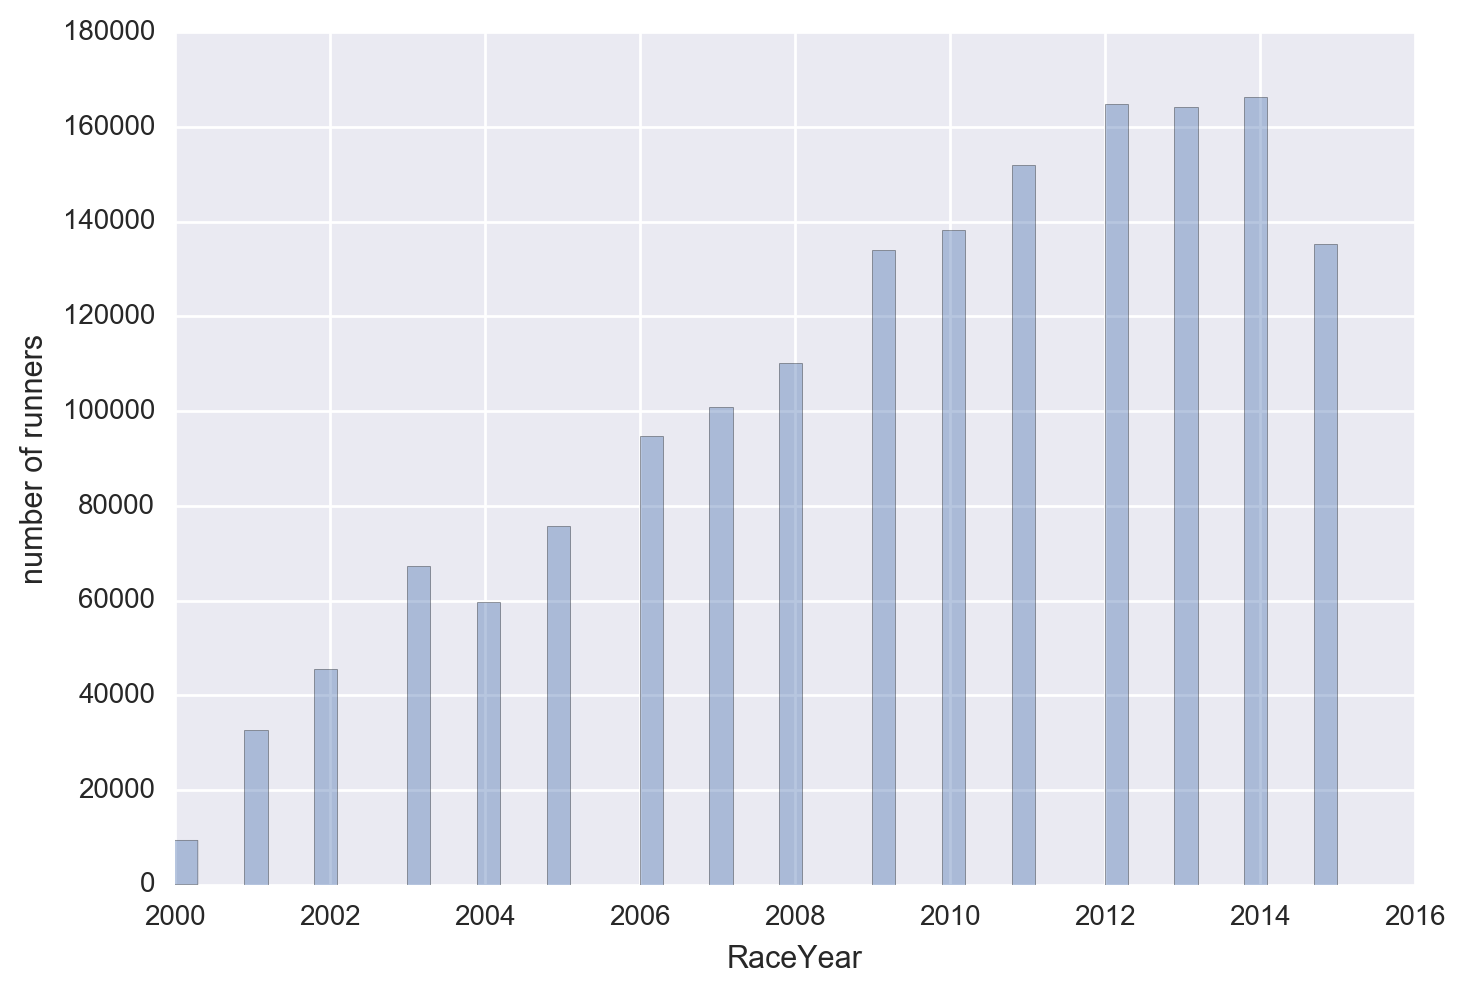

In [9]:
sns.distplot(full_df.RaceYear,kde=False)
plt.ylabel('number of runners');

It might be also intersting to see, in which month _along the year_, most of the events happened:

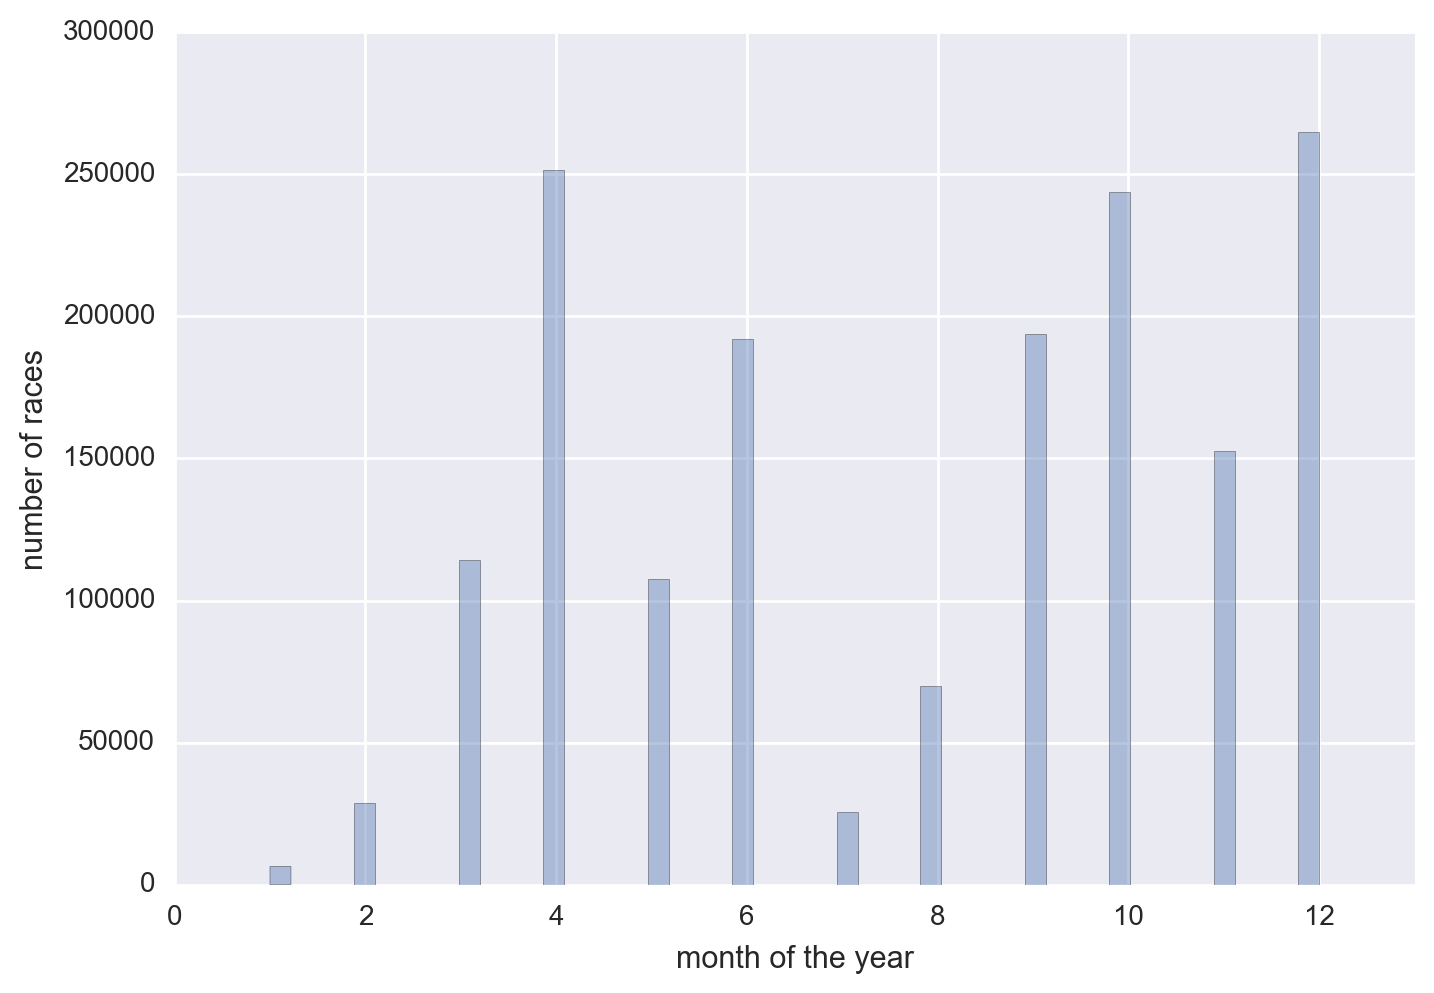

In [14]:
sns.distplot(full_df.RaceMonth,kde=False)
plt.xlabel('month of the year')
plt.xlim([0,13])
plt.ylabel('number of races');

### Distribution of #editions, per race

In [23]:
print('Number of unique races:',full_df.Race.nunique())

Number of unique races: 224


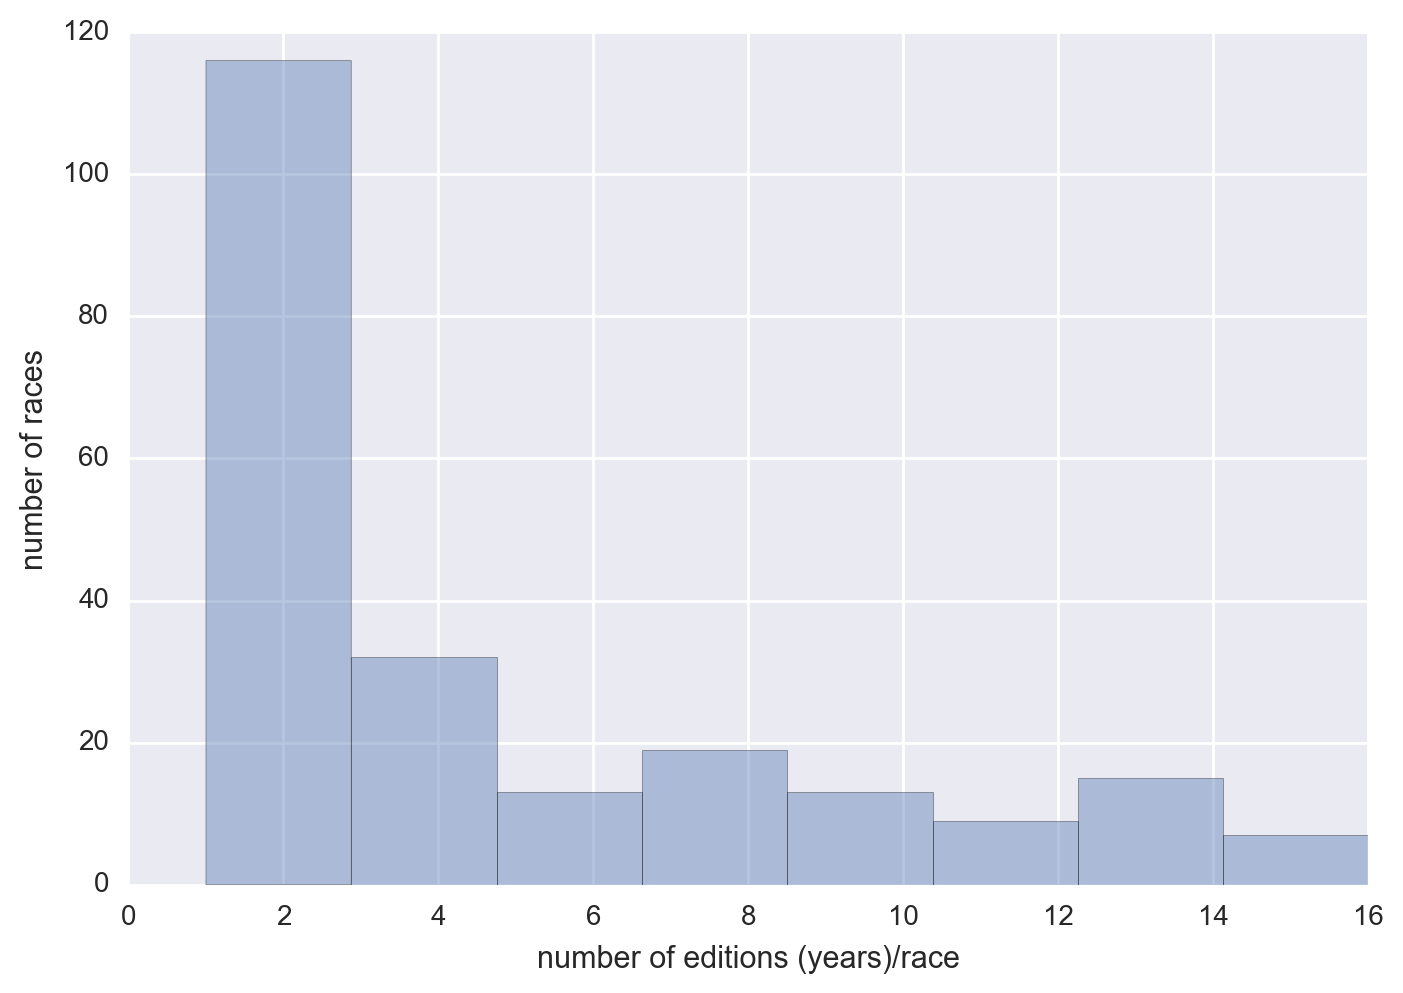

In [24]:
fast_edi_count = full_df.groupby('Race').RaceYear.nunique()

sns.distplot(fast_edi_count.values,kde=False)
plt.xlabel('number of editions (years)/race')
plt.ylabel('number of races');

These are the first 20 __most frequent races__ in the history:

In [25]:
sorted(fast_edi_count.items(),key=lambda x:x[1],reverse=True)[:20]

[('Chäsitzerlouf, Kehrsatz', 16),
 ('20km de Lausanne', 15),
 ('Basler Stadtlauf', 15),
 ('Frauenfelder', 15),
 ('Gurtenclassic, Wabern', 15),
 ('Kerzerslauf', 15),
 ('Schweizer Frauenlauf Bern', 15),
 ('Badener Limmat-Lauf, Baden', 14),
 ('Dietiker Neujahrslauf, Dietikon', 14),
 ('GP Fricktal, Eiken', 14),
 ('Hallwilerseelauf, Beinwil am See', 14),
 ('Kyburglauf, Kyburg', 14),
 ('Langenthaler Stadtlauf', 14),
 ('Pfingstlauf Wohlen AG', 14),
 ('ASICS Bremgarter Reusslauf', 13),
 ("Course de l'Escalade, Genève", 13),
 ('Hellebardenlauf Sempach', 13),
 ('Steinhölzlilauf, Liebefeld', 13),
 ('Thuner Stadtlauf, Thun', 13),
 ('Walliseller Lauf, Wallisellen', 13)]

### Distribution of #runners, per race  
(how popular is a race?)

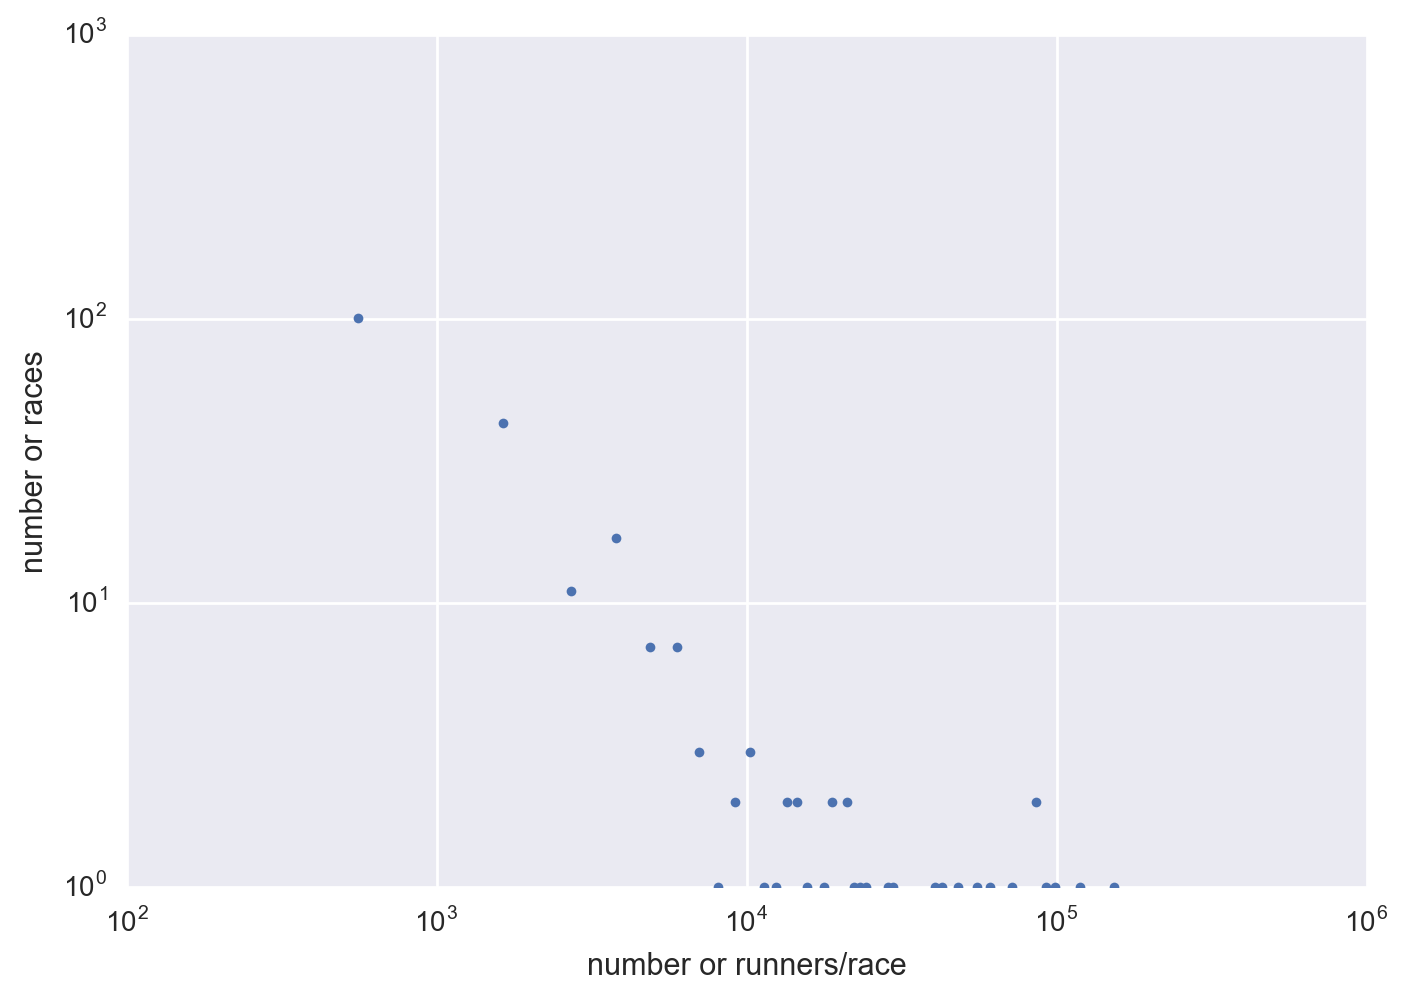

In [28]:
my_hist, bin_edges = np.histogram(full_df.Race.value_counts(),bins='fd')
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

plt.loglog(bin_centers,my_hist,marker='.',linestyle='')

plt.ylabel('number or races')
plt.xlabel('number or runners/race');

### Distribution of #races, per runner
(how active is a runner?)

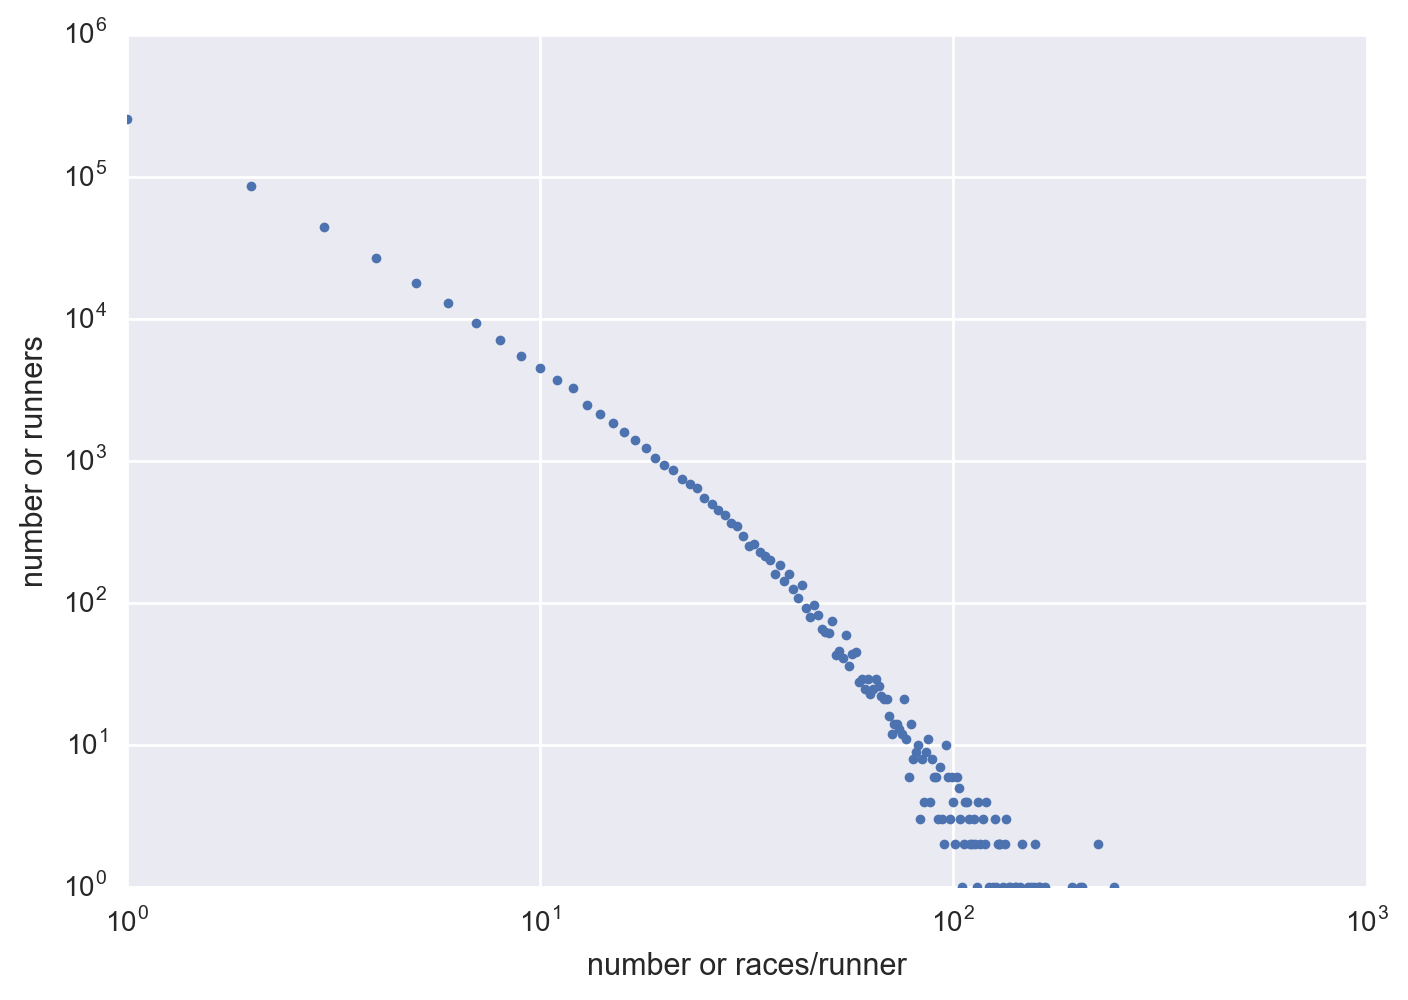

In [31]:
plt.loglog(full_df.Name.value_counts().value_counts(),marker='.',linestyle='')
plt.ylabel('number or runners')
plt.xlabel('number or races/runner');

### Performance VS Age  

This question has been already investigated in recent studies, on different races across the world. Here are few examples, from 
[2014(1)](http://bmcsportsscimedrehabil.biomedcentral.com/articles/10.1186/2052-1847-6-31),
[2014(2)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4039284/),
[2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4541133/),
[2016](http://www.sciencedirect.com/science/article/pii/S2095254615000435).

All of them found a _U-shaped dependence_, for both males and females

Let's consider for simplicity the largest races:

In [35]:
runners_count = full_df.Race.value_counts().sort_values(ascending=False)
runners_count[:20]

Course de l'Escalade, Genève            153253
Schweizer Frauenlauf Bern               118980
20km de Lausanne                         98815
Morat-Fribourg                           91958
Kerzerslauf                              86338
Zürcher Silvesterlauf, Zürich            86317
Int Greifenseelauf, Uster                71853
Zürich Marathon, Teamrun und Cityrun     60687
Basler Stadtlauf                         55904
Hallwilerseelauf, Beinwil am See         48329
Jungfrau-Marathon, Interlaken            42609
Lausanne Marathon                        39961
Lucerne Marathon, Luzern                 29941
ASICS Bremgarter Reusslauf               28394
SwissCityMarathon - Lucerne, Luzern      24460
Corrida Bulloise, Bulle                  22903
Luzerner Stadtlauf                       22658
Stralugano, Lugano                       21552
Winterthur Marathon                      20552
Frauenfelder                             19401
Name: Race, dtype: int64

#### Check races distances for each event  
We consider _only races with standard running distances_ - like, 10Km, 20Km, 1/2 marathon and marathon.  
Here are some examples:

In [36]:
full_df[full_df.Race=='20km de Lausanne'].Distance.unique()

array([ 20.,  18.,   4.,  10.,   2.])

In [37]:
full_df[full_df.Race=='Schweizer Frauenlauf Bern'].Distance.unique()

array([  5.,  10.])

In [38]:
full_df[full_df.Race=='Zürich Marathon, Teamrun und Cityrun'].Distance.unique()

array([ 42.,  10.])

In [39]:
full_df[full_df.Race=='Lucerne Marathon, Luzern'].Distance.unique()

array([ 42.,  21.,   8.])

In [40]:
full_df[full_df.Race=='SwissCityMarathon - Lucerne, Luzern'].Distance.unique()

array([ 21.,   9.,  42.])

In [41]:
full_df[full_df.Race=='Winterthur Marathon'].Distance.unique()

array([ 21.,  42.,  10.,   1.,   5.])

In [42]:
full_df[full_df.Race=='Lausanne Marathon'].Distance.unique()

array([ 10.,  21.,  42.,   4.,   3.,   1.,   2.])

#### Subsetting data

In [43]:
good_races = full_df.Race.isin(['20km de Lausanne','Lausanne Marathon','Winterthur Marathon',
                                'SwissCityMarathon - Lucerne, Luzern','Lucerne Marathon, Luzern',
                                'Zürich Marathon, Teamrun und Cityrun','Schweizer Frauenlauf Bern'])

In [45]:
marathon_distance = full_df.Distance == 42

#### Plot       data for marathon

ValueError: Could not convert object to NumPy timedelta

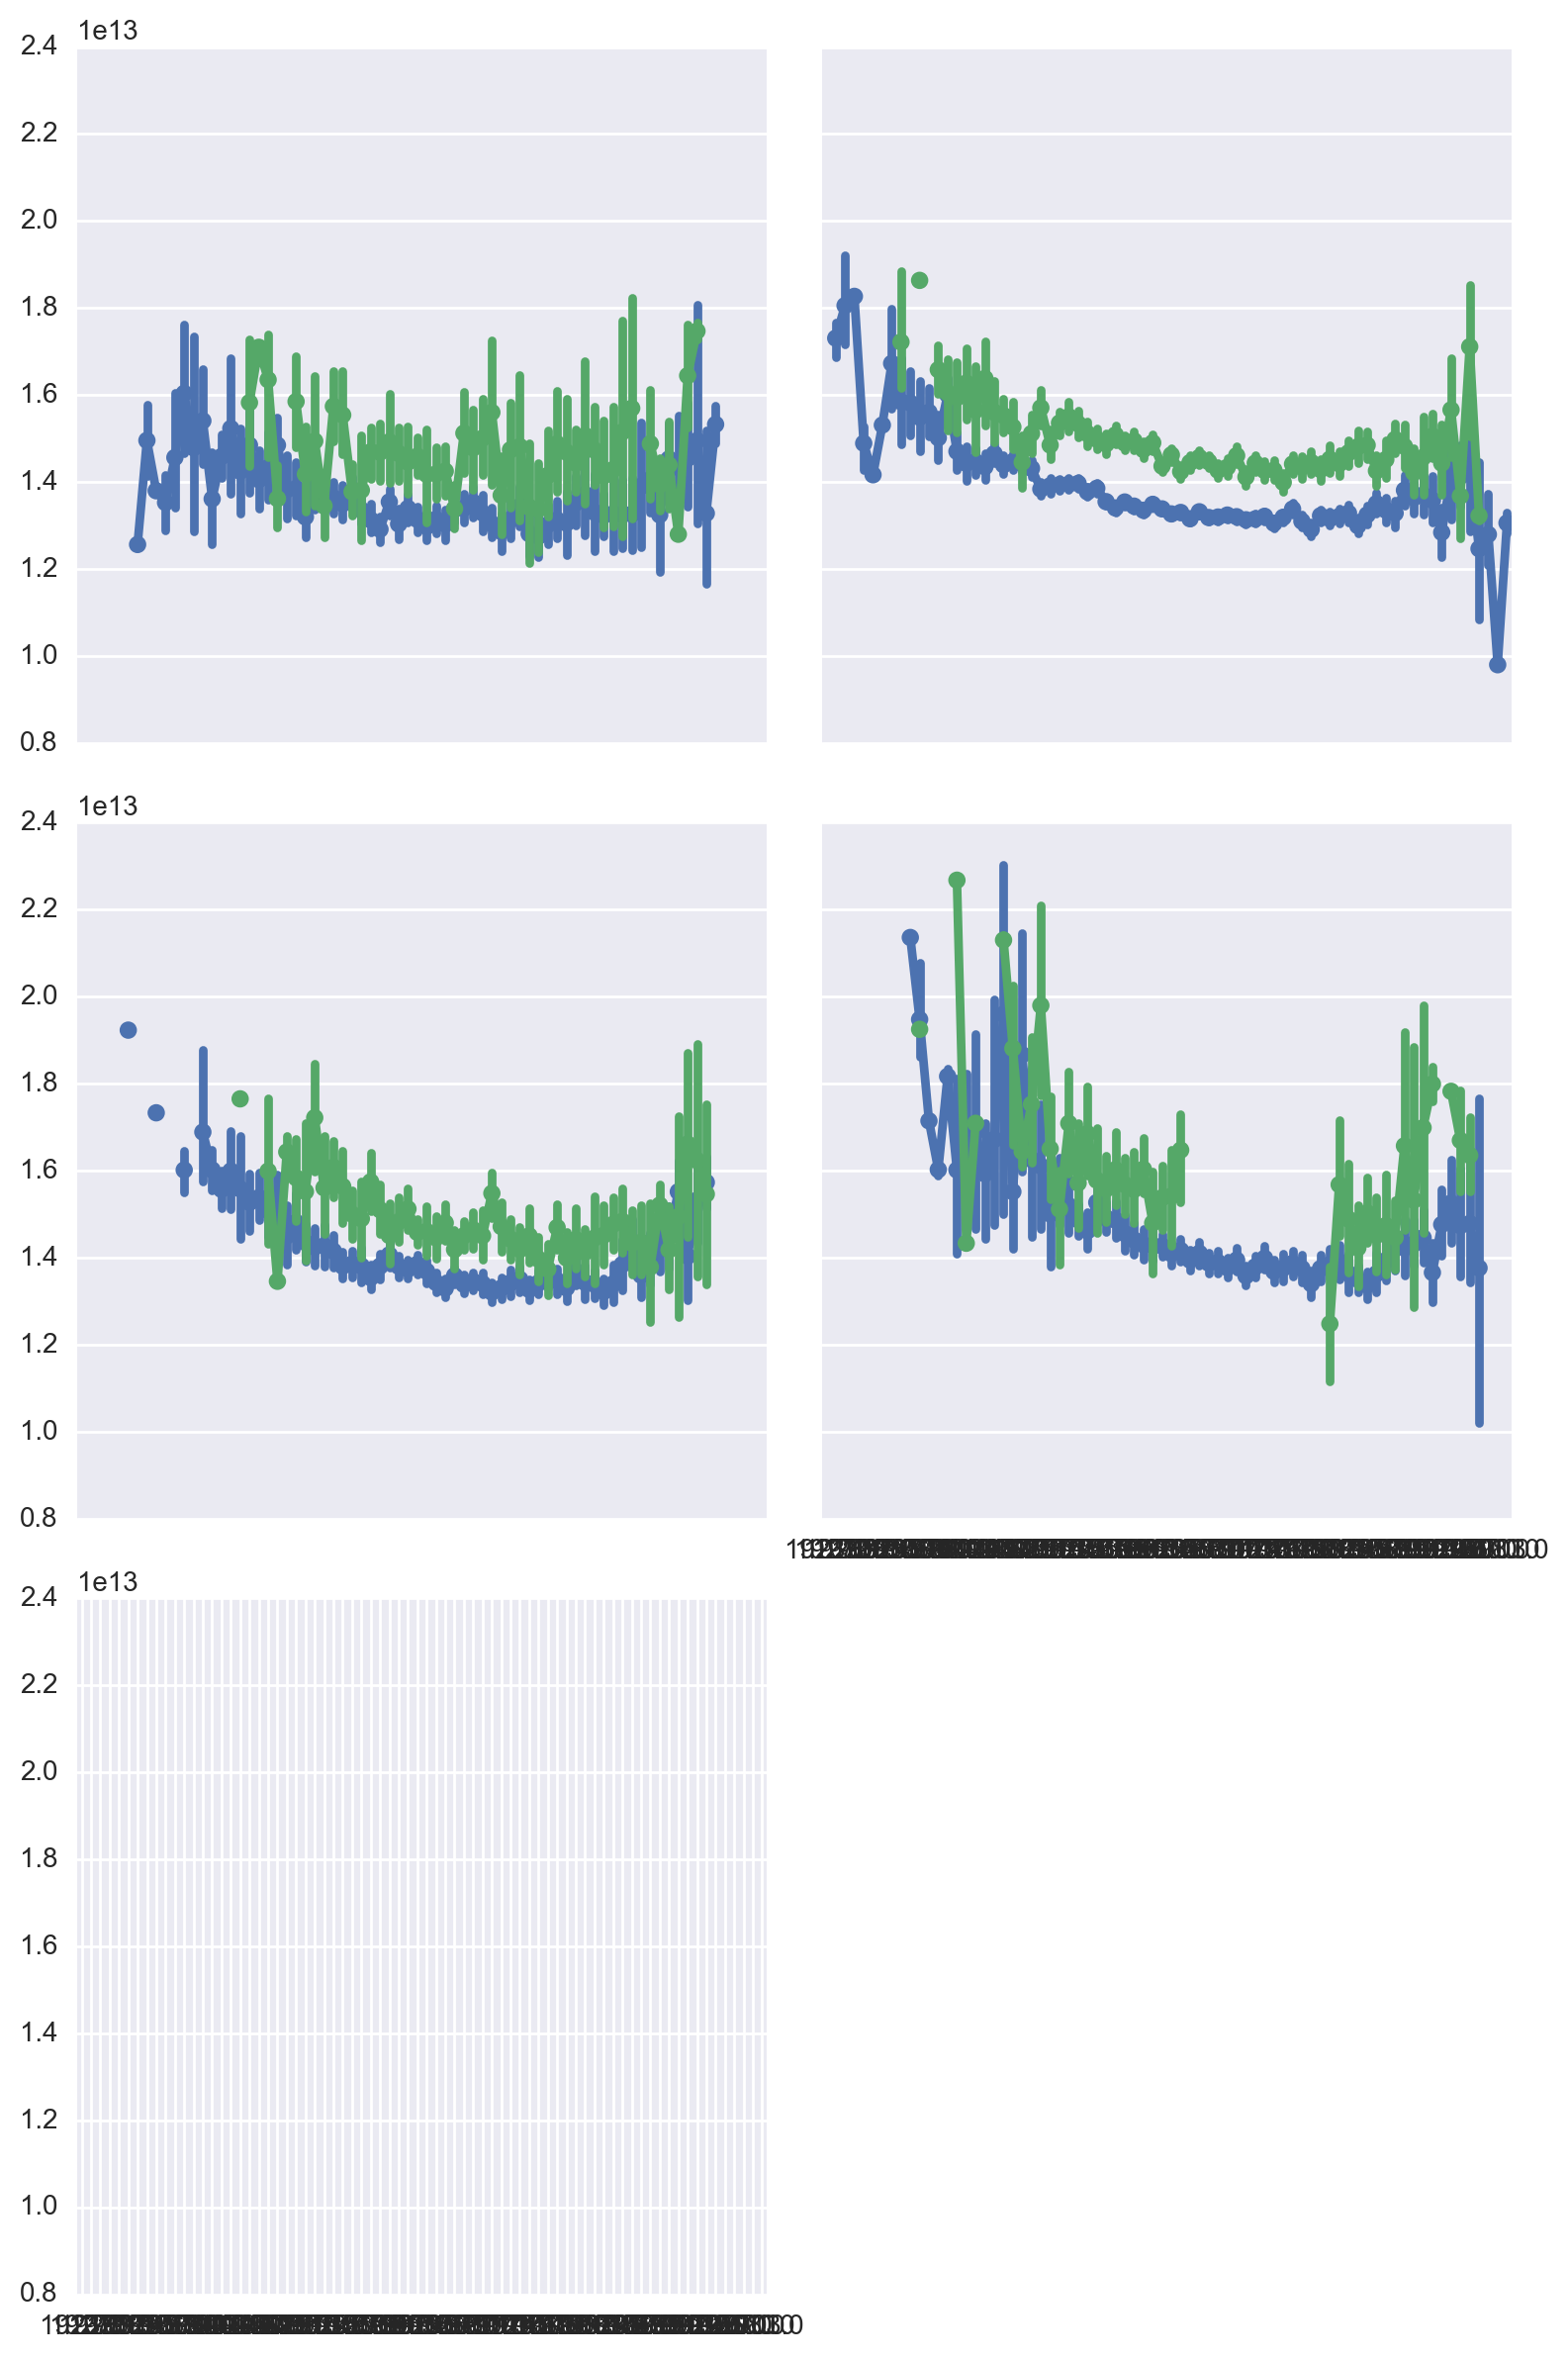

In [48]:
sns.factorplot(data=full_df[good_races & marathon_distance],x='Year',y='Time',
               hue='Sex',col='Race',col_wrap=2,markers='.',ms=0.5);
# markersize=0.5,linewidth=1
#                kind='box',

### Performance VS Weather

One of the main study on this topic, from 
[2007](http://journals.lww.com/acsm-msse/pages/articleviewer.aspx?year=2007&issue=03000&article=00012&type=abstract), found correlation between 
[WBGT](https://en.wikipedia.org/wiki/Wet-bulb_globe_temperature)
and decrease of performance, both for male and female runners.  
(An older study from 
[1997](http://journals.lww.com/acsm-msse/pages/articleviewer.aspx?year=1997&issue=09000&article=00018&type=abstract)
found similar negative effects of ambient temperature on resistance in cyclists)

#### exploring features

In [40]:
# sns.jointplot(full_df.groupby('Race').MinTemp.unique(),
#               full_df.groupby('Race').MaxTemp.unique(),
#               kind='kde');

## ML-driven analysis

### Prediction of athletes' career progression

This article on 
[fivethirtyeight](http://fivethirtyeight.com/features/tell-us-two-things-and-well-tell-you-how-fast-youd-run-a-marathon/) 
summarises the results of a recent 
[study](https://bmcsportsscimedrehabil.biomedcentral.com/articles/10.1186/s13102-016-0052-y).
The authors improved a long-standing prective model from 
[1981](http://www.runscore.com/coursemeasurement/Articles/ARHE.pdf),
that estimates the performance (min) of an athlete on the next race, based the distance and performance on the previous one.

In [2]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# ------   OLD CODE ------

In [6]:
# num_runners = 0

# for name in  full_df.Name.unique():
            
#     num_runners += full_df[full_df.Name==name].Year.nunique()